# Introduction to Word Embeddings: _Toronto_ : _UofT_ :: _Vancouver_ : ?

UBC Master of Data Science program, 2018-19

Instructor: Varada Kolhatkar [ʋəɾəda kɔːlɦəʈkər]

### Today's plan

- Set the stage (~5 mins)
- Sample class (~40 mins)
    - What is NLP? (~2 min)
    - Meaning representation (~10 min)
    - Word2Vec (~20 mins)
    - Pre-trained embeddings (~5 mins)
- Reflection (~)
- Vision (~10 mins)


#### Set the stage

- I am envisioning this as the second lesson of DSCI 575 (Advanced Machine Learning in the context of Language Processing (NLP) applications). 


- The first lesson was introductory and 
- It is the  first week of the final block of the MDS program's curriculum. 
- The students have already taken four Machine Learning courses: DSCI 571, DSCI 572, DSCI 573, DSCI 563. 
- They are now ready to apply the concepts they have learned so far on interesting problems. 
- any prerequisites you might be assuming, and other relevant information.

#### Today's class: Learning outcomes
From this lecture, students are expected to be able to:

- explain the general idea of word embeddings 
- use word embeddings 


40  minute class: We  will then shift  into role-playing mode,  with you
  teaching the class as you really would, and the audience behaving (or at
  least, trying to behave) as students  appropriate to the course you have
  chosen, doing any exercises you ask us to, asking questions as simulated
  students, etc. During this time,  do *not* make meta-comments about your
  teaching, other than what you might actually say to a real class.


#### Reflection 
+  10 minute  reflection:  Once you  complete the  sample  class, we  stop
  role-playing and return to behaving like normal Faculty members, and you
  have the opportunity to present

        (1) an organized reflection on  the sample class (e.g., addressing
        pedagogical issues you considered  when developing this class, the
        lecture structure and presentation choices you made and why);

        (2) your broader vision of pedagogy;

        (3)  how  you  see  yourself  contributing  to  the  departmental,
        university, and broader computing communities.


#### Vision 

+ 10  minute  presentation:  we   are   interested  in   your   vision  of
  undergraduate and  graduate data science  education at UBC, and  how you
  might contribute to that. We have attached a draft version of a proposal
  for a Minor in Data Science program for your perusal.

+ 10 minute Q&A: We will end with a lively Q&A. It is likely that you will
  get questions during your reflection period and presentation as well.


In [56]:
import pandas as pd
import numpy as np
import os, sys
from IPython.display import display, HTML

import matplotlib.pyplot as plt

from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from scipy.sparse import coo_matrix, csr_matrix

import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords

import re
from collections import defaultdict
from collections import Counter

plt.rcParams['font.size'] = 16
from preprocessing import MyPreprocessor

In [57]:
# BEGIN STARTER CODE
class CooccurrenceMatrix:
    def __init__(self, corpus, 
                       tokenizer = word_tokenize, 
                       window_size = 3):
        self.corpus = corpus
        self.tokenizer = tokenizer
        self.window_size = window_size
        self.vocab = {}
        self.cooccurrence_matrix = None    
        
    def fit_transform(self):
        """
        Creates a co-occurrence matrix. 
        
        Returns vocabulary (dict) and co-occurrence matrix (csr_matrix)
        """
        data=[]
        row=[]
        col=[]
        for tokens in self.corpus:
            for target_index, token in enumerate(tokens):
                # Get the index of the word in the vocabulary. If the word is not in the vocabulary, 
                # set the index to the size of the vocabulary. 
                i = self.vocab.setdefault(token, len(self.vocab))
                
                # Consider the context words depending upon the context window 
                start = max(0, target_index - self.window_size)
                end = min(len(tokens), target_index + self.window_size + 1)
                
                for context_index in range(start, end):
                    # Do not consider the target word.  
                    if target_index == context_index: 
                        continue                        
                    j = self.vocab.setdefault(tokens[context_index], len(self.vocab))
                    # Set diagonal to 0
                    if i == j:
                        continue
                    data.append(1.0); row.append(i); col.append(j);
        self.cooccurrence_matrix = csr_matrix((data,(row,col)))
        return self.vocab, self.cooccurrence_matrix
            
    def get_word_vector(self, word):
        """
        Given a word returns the word vector associated with it from the co-occurrence matrix. 

        Keyword arguments:
        word -- (str) the word to look up in the vocab.
        """
        # YOUR CODE HERE
        # BEGIN SOLUTION
        if word in self.vocab: 
            return self.cooccurrence_matrix[self.vocab[word]]
        else:
            print('The word not present in the vocab')
        # END SOLUTION

# END STARTER CODE

### Last class: What is Natural Language Processing (NLP)?
#### How often do you search everyday? 
<img src="images/Google_search.png" width="900" height="900">

## Last class: What is Natural Language Processing (NLP)?

<img src="images/WhatisNLP.png" width="900" height="900">

## Why is it hard?

- Language is complex and subtle. 
- Language is ambiguous at different levels. 
- Language understanding involves common-sense knowledge and real-world reasoning.
- All the AI problems related to representation and reasoning arise in this domain. 

## Example: Lexical ambiguity

<img src="images/lexical_ambiguity.png" width="800" height="800">

## Example: Part-of-speech ambiguity

<img src="images/pos_ambiguity.png" width="800" height="800">

## Example: Referential ambiguity

<img src="images/referential_ambiguity.png" width="800" height="800">

#### Today's promise

- A method that learns a powerful representation of text data.  

#### Learning outcomes

From this class, you will be able to 

- Explain the general idea of the vector space models and co-occurrence matrices.
- Explain the difference between sparse and dense word vectors.
- Explain the general idea of the continuous skip-gram model.
- Train your own word vectors with Gensim and work with dense word vectors. 
- Load pre-trained word embeddings.

### Text data

- So far we have been using data that looks like this: 

$X = \begin{bmatrix}1 & 0.8 & 0.3\\ 0 & 0 & 0.4\\ 1 & 0.2 & 0.8\\ \end{bmatrix}$ and $y = \begin{bmatrix}1 \\ 0 \\ 1 \end{bmatrix}$

- But consider data that looks like this instead: 

          
$X = \begin{bmatrix}\text{"@united you're terrible. You don't understand safety",}\\ \text{"@JetBlue safety first !! #lovejetblue"}\\ \text{"@SouthwestAir truly the best in #customerservice!"}\\ \end{bmatrix}$ and $y = \begin{bmatrix}0 \\ 1 \\ 1 \end{bmatrix}$

- ML algorithms we have seen so far prefer well-defined and fixed length input/output and text data is usually messy. 
- How can we effectively represent these reviews using features? 
    - Ideally we want to capture the "meaning" of text in our representation. 

### Word meaning: _cup_ or _bowl_?

- Philosophical debate: Where does the category cup end?
- Labov, 1975

<center>
<img src="files/images/Labov_cups.png" width="600" height="600">
</center>

### Word meaning: NLP view
- Modeling word meaning that allows us to 
    * draw useful inferences to solve meaning-related problems 
    * find relationship between words, e.g., which words are similar, which ones have positive or negative connotations

### Pair-share (~5 mins) 

- Suppose you are building a Question Answering system and you are given the following question and three candidate answers. 
- Brainstorm possible representations of this text that you would use so that the system returns the correct answer.  
- Goal: Want a representation
    - that captures at least some aspects of its meaning
    - that allows us to feed it into Machine Learning algorithms    
<blockquote>    
<p style="font-size:30px"><b>Question:</b> How <b>tall</b> is Machu Picchu?</p>
    <p style="font-size:30px"><b>Candidate 1:</b> Machu Picchu is 13.164 degrees south of the equator.</p>    
<p style="font-size:30px"><b>Candidate 2:</b> The official height of Machu Picchu is 2,430 m.</p>
<p style="font-size:30px"><b>Candidate 3:</b> Machu Picchu is 80 kilometres (50 miles) northwest of Cusco.</p>    
</blockquote> 
    

In [59]:
corpus = ["How tall is Machu Picchu?",
          "Machu Picchu is 13.164 degrees south of the equator.", 
          "The official height of Machu Picchu is 2,430 m.",
          "Machu Picchu is 80 kilometres (50 miles) northwest of Cusco."
         ]
pp = MyPreprocessor()
pp_corpus = pp.preprocess_corpus(corpus)
pp_corpus

[['tall', 'machu', 'picchu'],
 ['machu', 'picchu', '13.164', 'degrees', 'south', 'equator'],
 ['official', 'height', 'machu', 'picchu', '2,430'],
 ['machu', 'picchu', '80', 'kilometres', '50', 'miles', 'northwest', 'cusco']]

In [60]:
vec = CountVectorizer(tokenizer = nltk.word_tokenize)
X = vec.fit_transform(corpus)

### Representation 1: Representing words as atomic symbols

- Build the **vocabulary** containing all unique words from the corpus 
- Represent each word as **one-hot** encoding
- A vector of length $V$ such that the value at word index is 1 and all other indices is 0

In [61]:
def get_onehot_encoding(word, vocab):
    onehot = np.zeros(len(vocab), dtype='float64')    
    onehot[vocab[word]] = 1
    print('one-hot encoding of the word "%s" is: %s' % (word, str(onehot)))
    return onehot

In [62]:
# Note: In the NLP community a text data set is referred 
# to as a **corpus** (plural: corpora).

vocab = vec.vocabulary_
word1 = 'tall'
onehot_word1 = get_onehot_encoding(word1, vocab)

word2 = 'height'
onehot_word2 = get_onehot_encoding(word2, vocab)

print("The dot product between %s and %s is: %d" % 
      (word1, word2, onehot_word1.dot(onehot_word2)))

one-hot encoding of the word "tall" is: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
 0.]
one-hot encoding of the word "height" is: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]
The dot product between tall and height is: 0


### Problem with one-hot encoding

-  The problem with this representation is that there is no inherent notion of relationship between words.

<center>
$\vec{height}.\vec{tall} = 0$ 
</center>

### Distributional hypothesis

<blockquote> 
    <p>You shall know a word by the company it keeps.</p>
    <footer>Firth, 1957</footer>        
</blockquote>

<blockquote> 
If A and B have almost identical environments we say that they are synonyms.
<footer>Harris, 1954</footer>    
</blockquote>    

Example: 

- Her **child** loves to play in the playground. 
- Her **kid** loves to play in the playground. 



### Representation 2: Term-term co-occurrence matrix

In [64]:
cm = CooccurrenceMatrix(pp_corpus)
vocab, comat = cm.fit_transform()
words = [key for key, value in sorted(vocab.items(), key = lambda item: (item[1],item[0]))]
df = pd.DataFrame(comat.todense(), 
                  columns = words, 
                  index = words,
                  dtype = np.int8
                 )
df.head()

,tall,machu,picchu,13.164,degrees,south,equator,official,height,"2,430",80,kilometres,50,miles,northwest,cusco
tall,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
machu,1,0,4,1,1,0,0,1,1,1,1,1,0,0,0,0
picchu,1,4,0,1,1,1,0,1,1,1,1,1,1,0,0,0
13.164,0,1,1,0,1,1,1,0,0,0,0,0,0,0,0,0
degrees,0,1,1,1,0,1,1,0,0,0,0,0,0,0,0,0


In [67]:
vec1 = cm.get_word_vector('tall')
vec2 = cm.get_word_vector('height')


  (0, 1)	1.0
  (0, 2)	1.0


In [22]:
### Let's check whether bag of words representation is better
bow_df = pd.DataFrame(X.toarray(), columns=sorted(vec.vocabulary_), index=corpus)
bow_df

,(,),.,13.164,"2,430",50,80,?,cusco,degrees,...,m,machu,miles,northwest,of,official,picchu,south,tall,the
How tall is Machu Picchu?,0,0,0,0,0,0,0,1,0,0,...,0,1,0,0,0,0,1,0,1,0
Machu Picchu is 13.164 degrees south of the equator.,0,0,1,1,0,0,0,0,0,1,...,0,1,0,0,1,0,1,1,0,1
"The official height of Machu Picchu is 2,430 m.",0,0,1,0,1,0,0,0,0,0,...,1,1,0,0,1,1,1,0,0,1
Machu Picchu is 80 kilometres (50 miles) northwest of Cusco.,1,1,1,0,0,1,1,0,1,0,...,0,1,1,1,1,0,1,0,0,0


In [47]:
### Let's examine the similarity between these three documents
for i in range(1,4,1):
    print('Question: %s \nCandidate: %s \nSimilarity = %0.3f\n\n' \
                          %(bow_df.index[0],bow_df.index[i], \
                            bow_df.iloc[0].dot(bow_df.iloc[i])))

Question: How tall is Machu Picchu? 
Candidate: Machu Picchu is 13.164 degrees south of the equator. 
Similarity = 3.000


Question: How tall is Machu Picchu? 
Candidate: The official height of Machu Picchu is 2,430 m. 
Similarity = 3.000


Question: How tall is Machu Picchu? 
Candidate: Machu Picchu is 80 kilometres (50 miles) northwest of Cusco. 
Similarity = 3.000




### Representation 3: Word embeddings

### Word2Vec
<img src="images/word2vec.png" width="700" height="700">


In [2]:
# Data loading and preprocessing
imdb_df = pd.read_csv('../../data/imdb_master.csv', encoding = "ISO-8859-1")
imdb_df = imdb_df[['review', 'label']]

# only consider positive and negative reviews
imdb_pos_neg_df = imdb_df[imdb_df['label'].str.startswith(('pos','neg'))]
df_train, df_test = train_test_split(imdb_pos_neg_df)

In [6]:
# Data loading and preprocessing
imdb_df = pd.read_csv('../../data/imdb_master.csv', encoding = "ISO-8859-1")
imdb_df = imdb_df[['review', 'label']]

# only consider positive and negative reviews
imdb_pos_neg_df = imdb_df[imdb_df['label'].str.startswith(('pos','neg'))]
df_train, df_test = train_test_split(imdb_pos_neg_df)

In [7]:
# A list of reviews labeled as 'pos'
pos_corpus = imdb_df[imdb_df['label'] == 'pos']['review'].tolist()

# A list of reviews labeled as 'neg'
neg_corpus = imdb_df[imdb_df['label'] == 'neg']['review'].tolist()

# A list of reviews labeled as 'unsup'
unsup_corpus = imdb_df[imdb_df['label'] == 'unsup']['review'].tolist()

imdb_pos_neg_corpus = pos_corpus + neg_corpus

# A list of all reviews
imdb_all_corpus = pos_corpus + neg_corpus + unsup_corpus
# END STARTER CODE

### Word representation using a dictionary 

- [WordNet](https://wordnet.princeton.edu/)
- A lexical database of English (and other languages) 
<center>
<img src="files/images/wordnet_graph.png" width="700" height="700">
</center>

### Sparsity problem of WordNet

- A static resource
- 10+ years of work by a number of linguists but still incomplete
- Not useful in specialized domains

Is it possible to build a non-static representation of words that can work for a variety of domains? 

### Questions?

In [39]:
from nltk.corpus import wordnet as wn
from nltk.wsd import lesk
# Shows definitions of different senses of the word **bank**
for ss in wn.synsets('bank','n'):
    print(ss, ss.definition())
# What's the meaning of the word bank in each context
print('\nMeaning of the word bank in different contexts.')®
print('----------------------')
print(lesk('bank deposits money'.split(), 'bank', 'n'))
print(lesk('body bank water'.split(), 'bank', 'n'))
print('\nMeaning of the word bank in different contexts.')
print('----------------------')
print(lesk('bank deposit money'.split(), 'bank', 'n'))
print(lesk('river bank water'.split(), 'bank', 'n'))

Synset('bank.n.01') sloping land (especially the slope beside a body of water)
Synset('depository_financial_institution.n.01') a financial institution that accepts deposits and channels the money into lending activities
Synset('bank.n.03') a long ridge or pile
Synset('bank.n.04') an arrangement of similar objects in a row or in tiers
Synset('bank.n.05') a supply or stock held in reserve for future use (especially in emergencies)
Synset('bank.n.06') the funds held by a gambling house or the dealer in some gambling games
Synset('bank.n.07') a slope in the turn of a road or track; the outside is higher than the inside in order to reduce the effects of centrifugal force
Synset('savings_bank.n.02') a container (usually with a slot in the top) for keeping money at home
Synset('bank.n.09') a building in which the business of banking transacted
Synset('bank.n.10') a flight maneuver; aircraft tips laterally about its longitudinal axis (especially in turning)

Meaning of the word bank in differe

### Vector space model

- Model the meaning of a word by placing it into a vector space.  
- Distances among words in the vector space indicate the relationship between them. 

<center>
<img src="files/images/t-SNE_word_embeddings.png" width="700" height="700">
    (Attribution: Jurafsky and Martin 3rd edition)
</center>



### Co-occurrence matrices
- A way to represent vectors into a vector space

#### Term-document matrix

- You have seen a transpose of this when you used `CountVectorizer` in DSCI 571. 
- Each cell is a count of words in the document in that column. 
- You can describe a document in terms of the frequencies of different words in it. 
- You can describe a word in terms of its frequency in different documents. 

In [13]:
corpus = ['information big data',
        'walnut sugar',
        'apricot big',
        'information data',
        'big data information']
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(corpus)
header = vectorizer.get_feature_names()
labels = ['D1', 'D2', 'D3', 'D4', 'D5']
df = pd.DataFrame(X.toarray(), columns = header, index = labels)  
df.transpose()

,D1,D2,D3,D4,D5
apricot,0,0,1,0,0
big,1,0,1,0,1
data,1,0,0,1,1
information,1,0,0,1,1
sugar,0,1,0,0,0
walnut,0,1,0,0,0


### Term-term matrix

- The idea is to go through a corpus of text, keeping a count of all of the words that appear in its context within a window.

In [14]:
corpus = ['information big data',
        'walnut sugar',
        'apricot big',
        'information data',
        'big data information']
vec = CountVectorizer(ngram_range=(1,1)) 
X = vec.fit_transform(corpus)
X_ww = (X.T.dot(X)) 
X_ww.setdiag(0) 
header = vec.get_feature_names()
ind_col = header
df = pd.DataFrame(X_ww.toarray(), columns = header, index = ind_col)  
df

,apricot,big,data,information,sugar,walnut
apricot,0,1,0,0,0,0
big,1,0,2,2,0,0
data,0,2,0,3,0,0
information,0,2,3,0,0,0
sugar,0,0,0,0,0,1
walnut,0,0,0,0,1,0


In [95]:
df_subset = df[['big','data']]
df_subset.iloc[2:]

,big,data
information,2,3
sugar,0,0
walnut,1,0


### Visualizing word vectors and angles

<img src="images/word_vectors_and_angles.png" width="800" height="400">
(Credit: Jurafsky and Martin 3rd edition)

$similarity_{cosine}(\vec{w_1},\vec{w_2}) = \frac{\vec{w_1}.\vec{w_2}}{\left\lVert w_1\right\rVert \left\lVert w_2\right\rVert}$  

### Visualizing word vectors and angles

<img src="images/word_vectors_and_angles.png" width="600" height="600">
(Credit: Jurafsky and Martin 3rd edition)

$similarity_{cosine}(\vec{\text{digital}},\vec{\text{information}}) = \frac{0 \times 1 + 1 \times 6}{\sqrt{1} \sqrt{1 + 36}} = 0.98$

$similarity_{cosine}(\vec{\text{apricot}},\vec{\text{information}}) = \frac{2 \times 1 + 0 \times 6}{\sqrt{4}\sqrt{1 + 36}} = 0.16$


### Questions?

### Sparse vs. dense word vectors

- Term-term and term-document matrices are sparse. 
- OK because there are efficient ways to deal with sparse matrices.


### Alternative 
- Learn short (~100 to 1000 dimensions) and dense vectors. 
- These short dense representations of words are referred to as **word embeddings**.
- Short vectors may be easier to train with ML models (less weights to train).
- They may generalize better.

### How can we get dense vectors?
 
- Count-based methods
    - Singular Value Decomposition (SVD)
- Prediction-based methods
    - [Word2Vec](https://github.com/tmikolov/word2vec)
    - [fastText](https://fasttext.cc/)
    - [GloVe](https://nlp.stanford.edu/projects/glove/)

## SVD

- A matrix factorization algorithm

   * Reduces a high-dimensional, highly variable dataset to a lower-dimensional space
   * Captures the substructure of the data more clearly 
   * Highest order dimension captures most variance in the original dataset
   * Next dimension captures the next most variance


## SVD 
- Let’s apply it to our term-term matrix $X$

<center>
$X_{V \times c} = W_{V \times m} \times \sum_{m \times m} \times C^T_{m \times c}$
</center>   

where, 
- $m$ is the rank of the matrix $X$
- Rows of $W$ are the new dense word vectors
- Rows of $C$ (columns of $C^T$) are the new context vectors. 
- $\sum$ is a diagonal matrix of the singular values of $X$ (the square root of the eigenvalues of $X^TX$, arranged from highest to lowest)

## Truncated SVD 
- Throw out some of the singular values in $\sum$

<center>
$X_{V \times c} = W_{V \times k} \times \sum_{k \times k} \times C^T_{k \times c}$
</center>   


In [8]:
from sklearn.decomposition import TruncatedSVD
from sklearn.random_projection import sparse_random_matrix

vec = CountVectorizer(ngram_range=(1,1), tokenizer=nltk.word_tokenize) 
X = vec.fit_transform(df_test['review'])
X_ww = (X.T.dot(X)) 
X_ww.setdiag(0) 
header = vec.get_feature_names()
ind_col = header
df = pd.DataFrame(X_ww.toarray(), columns = header, index = ind_col)  
#df

In [28]:
svd = TruncatedSVD(n_components=50, n_iter=7, random_state=42)
svd.fit(X_ww)
embedding_matrix = svd.transform(X_ww)
embedding_matrix[0]
# Show embedding for a specific word

### Success of Word2Vec

- Able to capture complex relationships between words.
- Example: What is the word that is similar to **WOMAN** in the same sense as **KING** is similar to **MAN**?
- Perform a simple algebraic operations with the vector representation of words.
    $\vec{X} = \vec{\text{KING}} − \vec{\text{MAN}} + \vec{\text{WOMAN}}$
- Search in the vector space for the word closest to $\vec{X}$ measured by cosine distance.

<img src="files/images/word_analogies1.png" width="500" height="500">
(Credit: Mikolov et al. 2013)    


### Questions? 

### Word2Vec 

- A family of models to get word vectors.
- We will focus on the continuous skip-gram model.
- Create a fake word prediction task. 
- Learn embeddings as part of the process of word prediction. 
- Use the learned weights as embeddings for the word. 
- No annotated data required!!

### Fake word-prediction task 

<center>
<blockquote>
    Add freshly squeezed <b>pineapple</b> juice to your smoothie. 
</blockquote> 
</center>

- Is the word **juice** likely to occur in the context of **pineapple**? 


### Context words and target word

- Given a *target* word, we define a **context window** and predict each word in the given context window.
- If the context window is $n$, consider $n$ preceding and $n$ following words of the target word.
- Example 
    * Sequence of words &rarr;  $w_{t-3}, w_{t-2}, w_{t-1}, w_t, w_{t+1}, w_{t+2}$
    * Target word &rarr; $w_t$
    * $n=2$
    * Context words &rarr;  $w_{t-2}, w_{t-1}, w_{t+1}, w_{t+2}$.
- Context window does not usually cross sentence boundaries. 

### Context words and target word

<center>
<blockquote>
    Add freshly squeezed <b>pineapple</b> juice to your smoothie . It will make your smoothie extra special . 
</blockquote> 
</center>

- What are the context words of the target word **pineapple** with the window size 2? 
- What are the context words of the target word **smoothie** with the window size 2?

### Questions? 

### Goal

Given a corpus with vocabulary of size $V$, where a word $w_i$ is identified by its index $i \in {1, ..., V}$, learn a vector representation for each $w_i$ by predicting the words that appear in its context. 

### Continuous skip-gram objective
- Consider the conditional probabilities $p(w_c|w_t)$ and set the parameters $\theta$ of $p(w_c|w_t; \theta)$ so as to maximize the corpus probability. 

<center>
$
\arg\max\limits_{\substack{\theta}} \prod\limits_{\substack{t=1}}^{\substack{T}}\prod\limits_{\substack{-m \leq c \leq +m \\ c\neq0}} p(w_c|w_t;\theta)\\
\arg \max\limits_\theta \prod\limits_{(w_c,w_t) \in D} p(w_c|w_t;\theta)
$
</center>

- $w_t$ &rarr; target word, $m$ &rarr; the context window size
- $D$ is the set of all word and context pairs from the text. 

### Modeling conditional probability

- Model the conditional probability using softmax of the dot product.
    * Higher the dot product higher the probability and vice-versa.     
    
<center>
$P(w_c|w_t;\theta) = \frac{exp(\vec{w_c}.\vec{w_t})}{\sum\limits_{\substack{c' \in V}} exp(\vec{w_{c'}}.\vec{w_t})}\\
$
</center>    

### Continuous skip-gram objective
   
<center>
$    
\arg \max\limits_\theta \prod\limits_{(w_c,w_t) \in D} p(w_c|w_t;\theta) \approx \prod\limits_{(w_c,w_t) \in D}\frac{exp(\vec{w_c}.\vec{w_t})}{\sum\limits_{\substack{c' \in V}} exp(\vec{w_{c'}}.\vec{w_t})}\\
\arg \max\limits_\theta \sum\limits_{(w_c,w_t) \in D} log\mbox{ }p(w_c|w_t;\theta) \approx \sum\limits_{(w_c,w_t) \in D} (log\mbox{ }exp(\vec{w_c}.\vec{w_t})  - log \sum\limits_{\substack{c' \in V}} exp(\vec{w_{c'}}.\vec{w_t}))
$    
</center>    


- Assumption: Maximizing this objective will results in good embeddings for all words in the vocabulary. 
- Learn two embeddings for each word: context embedding and target embedding. 

### Parameters of the model

- Suppose $V = 10,000$, $d = 300$, the number of parameters to learn are 6,000,000! 

<center>
$
\theta = 
\begin{bmatrix} aardvark_t\\
                aback_t\\
                \dots\\
                zymurgi_t\\
                aardvark_c\\
                aback_c\\                
                \dots\\
                zymurgi_c\\                
\end{bmatrix} \in R^{2dV}
$
</center>

<img src="images/skip-gram.png" width="1000" height="1000">


### Questions? 

### Problem with this model

<center>
$P(w_c|w_t;\theta) = \frac{exp(\vec{w_c}.\vec{w_t})}{\sum\limits_{\substack{c' \in V}} exp(\vec{w_{c'}}.\vec{w_t})}$
</center>

- Computationally expensive to calculate $\vec{w_c}.\vec{w_t}$

### Continuous skip-gram with negative sampling (SGNS)

- Frame the problem of predicting context words as a set of independent binary classification tasks. 
    * Is the context word $w_c$ likely to show up near the target word $w_t$?
    * Example: Is _juice_ likely to show up near _pineapple_?
- Create positive samples using context words and negative samples using 'noise' words. 

### Continuous skip-gram with negative sampling (SGNS)

- A 'noise' word is a random word from the vocabulary, constrained not to be the target word. 
- SGNS uses more noise words than context words; the ratio is set by a parameter. 

<blockquote>
<p>Add freshly <b>squeezed pineapple juice</b> in your smoothie.</p>
</blockquote>
<img src="images/negative_sampling.png" width="800" height="500">

### SGNS classifier

Given: target $w_t$ and context $w_c$
- The classifier gives the probability of the class being positive. 
$P(+|w_t,w_c)$ 
- How to calculate this probability?
    * Based on the dot product similarity
    * $w_t$ and $w_c$ are similar $\vec{w_t}.\vec{w_c}$ is high
    * Use sigmoid to convert it into probabilities 
       

### SGNS classifier

Probabilistic classifier that assigns a probability to a target word and context window based on how similar the context widow is to the target word. 

$P(+|w_t,w_c) = \sigma(\vec{w_t}.\vec{w_c}) = \frac{1}{1+ exp(-\vec{w_t}.\vec{w_c})}$ 

$P(-|w_t,w_c) = 1 - P(+|w_t,w_c) = \frac{exp(-\vec{w_t}.\vec{w_c})}{1 + exp(\vec{w_t}.\vec{w_c})}$ 

For $k$ context words: Independence assumption

$P(+|w_t,w_{c_{1:k}}) \approx \prod\limits_{i=1}^{k}\frac{1}{1+ exp(-\vec{w_t}.\vec{w_{c_i}})} \approx \sum\limits_{i=1}^{k} log \frac{1}{1+ exp(-\vec{w_t}.\vec{w_{c_i}})}$ 



### Learning embeddings

We can use this classifier if we had learned embeddings. 

How do we learn embeddings? 

### Learning objective

- Maximize the dot product of the target word with the actual context word.
- Minimize the dot product of the target word with the 'noise' context word.  

<center>
$L(\theta) = \sum\limits_{w_t,w_c \in +} P(+|w_t,w_c) + \sum\limits_{w_t,w_c \in -} P(-|w_t,w_c)$
</center>

### Learning objective

- For one positive and $k$ negative examples: 

<center>
$log \frac{1}{1+exp(-\vec{w_t}.\vec{w_c})} + \sum\limits_{i = 1}^{k} log \frac{1}{1+exp(\vec{w_t}.\vec{w_c}_i)}$
</center>

- Train the objective with stocastic gradient descent.
    * Iteratively modify the embeddings for each word and each context word or noise word to maximize the objective

### Questions? 

### Main hyperparameters of the model

- Dimensionality of the word vectors 
- Window size
    * shorter window: more syntactic representation
    * longer window: more semantic representation 
    * Mikolov et al. (2015) suggest setting this parameter in the range 5 to 20 for small training datasets and in the range 2 to 5 for large training datasets. 
    
- Number of 'noise' samples
    * the number of noise examples to extract

In [111]:
from keras.preprocessing import text

corpus = [
          "How do you cause people to believe in an imagined order such as Christianity, democracy or capitalism? You could never convince a monkey to give you a banana by promising him limitless bananas after death in monkey heaven.",
          "Data science is a multidisciplinary blend of data inference, algorithmm development, and technology in order to solve analytically complex problems.",
          "In the world of data science, raw data comes in many forms and sizes. There is a lot of information that can be extracted from this raw data.",          
          "One of history’s few iron laws is that luxuries tend to become necessities and to spawn new obligations.",
          "The capitalist and consumerist ethics are two sides of the same coin, a merger of two commandments.",
          "The book introduces the core libraries essential for working with data in Python: particularly IPython, NumPy, Pandas, Matplotlib, Scikit-Learn, and related packages."
         ]

tokenizer = text.Tokenizer()
tokenizer.fit_on_texts(corpus)

word2id = tokenizer.word_index
id2word = {v:k for k, v in word2id.items()}

vocab_size = len(word2id) + 1 
embed_size = 100

wids = [[word2id[w] for w in text.text_to_word_sequence(doc)] for doc in corpus]
print('Vocabulary Size:', vocab_size)
print('Vocabulary Sample:', list(word2id.items())[:10])

Using TensorFlow backend.


Vocabulary Size: 104
Vocabulary Sample: [('in', 1), ('data', 2), ('of', 3), ('to', 4), ('a', 5), ('and', 6), ('the', 7), ('you', 8), ('is', 9), ('order', 10)]


In [112]:
from keras.preprocessing.sequence import skipgrams
# generate skip-grams
skip_grams = [skipgrams(wid, vocabulary_size=vocab_size, window_size=10) for wid in wids]

# view sample skip-grams
pairs, labels = skip_grams[0][0], skip_grams[0][1]
for i in range(10):
    print("({:s} ({:d}), {:s} ({:d})) -> {:d}".format(
          id2word[pairs[i][0]], pairs[i][0], 
          id2word[pairs[i][1]], pairs[i][1], 
          labels[i]))

(people (19), believe (20)) -> 1
(cause (18), related (102)) -> 0
(as (24), history’s (66)) -> 0
(in (1), order (10)) -> 0
(give (32), capitalism (28)) -> 1
(in (1), as (24)) -> 1
(capitalism (28), you (8)) -> 1
(imagined (22), learn (101)) -> 0
(imagined (22), you (8)) -> 1
(a (5), monkey (11)) -> 1


### Training word2vec embeddings 

- [Original C code](https://code.google.com/archive/p/word2vec/) 
- [GitHub version of the code](https://github.com/tmikolov/word2vec)
- [Gensim](https://radimrehurek.com/gensim/), an open source Python library has provides a Python interface for word2vec family of algorithms

In [40]:
import gensim
from gensim.test.utils import common_texts
from gensim.models import Word2Vec, KeyedVectors, FastText
common_texts

[['human', 'interface', 'computer'],
 ['survey', 'user', 'computer', 'system', 'response', 'time'],
 ['eps', 'user', 'interface', 'system'],
 ['system', 'human', 'system', 'eps'],
 ['user', 'response', 'time'],
 ['trees'],
 ['graph', 'trees'],
 ['graph', 'minors', 'trees'],
 ['graph', 'minors', 'survey']]

In [115]:
model = Word2Vec(common_texts, 
                 size=100, 
                 window=5, 
                 min_count=1,
                 sg=1, 
                 negative=4
                )
model.wv['trees']

array([ 9.2323427e-04, -3.7498914e-03, -1.0925164e-03,  4.2397971e-03,
       -4.9607465e-03, -3.0870349e-04, -4.2083981e-03, -1.0050529e-03,
       -3.6563925e-03, -2.0536014e-03, -4.1735778e-03, -3.0919104e-03,
       -1.3408327e-03, -5.3132912e-06,  4.8371986e-03, -2.9660651e-04,
        3.6825459e-03,  1.1264496e-03, -7.1753206e-04,  3.8768593e-03,
       -3.9951899e-03,  8.2737493e-04, -5.1536004e-04, -4.2715762e-03,
       -1.7228299e-04, -4.8794928e-03,  3.5386748e-04,  3.2548017e-03,
       -3.3760341e-03, -6.9915433e-04, -3.9494857e-03,  1.4217952e-03,
        3.4251781e-03,  2.1118931e-03, -1.0717013e-04,  9.5226412e-04,
       -3.8584864e-03, -1.5147211e-03,  4.9362383e-03, -1.3717329e-05,
       -4.5704949e-03,  3.2199575e-03,  2.1144950e-03,  2.8104316e-03,
       -1.5968647e-04,  3.1935051e-03,  2.0830643e-03, -2.1148981e-03,
        3.0582487e-03, -4.1969675e-03, -2.4907924e-03, -3.9028623e-03,
        3.0177895e-03,  3.3060035e-03,  1.1344628e-03, -1.7954281e-03,
      

### Other popular methods to get embeddings

### [fastText](https://fasttext.cc/)

- NLP library by Facebook research  
- Includes an algorithm which is an extension to Word2Vec
- Helps dealing with unknown words elegantly
- Breaks words into several n-gram subwords 
- Example: trigram sub-words for *berry* are *ber*, *err*, *rry*)
- Embedding(*berry*) = embedding(*ber*) + embedding(*err*) + embedding(rry)

### [GloVe: Global Vectors for Word Representation](https://nlp.stanford.edu/projects/glove/)
- Starts with the co-occurrence matrix
    - co-occurrence can be interpreted as an indicator of semantic proximity of words
- Takes advantage of global count statistics    
- Predicts co-occurrence ratios
- Loss based on word frequency

### Pre-trained embeddings

Why? 
- Training embeddings is computationally expensive
- For large corpora, the vocabulary size is more that 100,000.  
- If the size of embeddings is 300, the number of parameters of the model is $2 \times 30,000,000$

### Pre-trained embeddings

A number of pre-trained word embeddings are available. The most popular ones are:  

- [word2vec](https://code.google.com/archive/p/word2vec/)
    * trained on several corpora using the word2vec algorithm 
- [GloVe](https://nlp.stanford.edu/projects/glove/)
    * trained using [the GloVe algorithm](https://nlp.stanford.edu/pubs/glove.pdf) 
    * published by Stanford University 
- [fastText pre-trained embeddings for 294 languages](https://fasttext.cc/docs/en/pretrained-vectors.html) 
    * trained using [the fastText algorithm](http://aclweb.org/anthology/Q17-1010)
    * published by Facebook

In [114]:
# Load Google's pre-trained Word2Vec model.
model = KeyedVectors.load_word2vec_format('../../data/GoogleNews-vectors-negative300.bin', binary=True)

In [91]:
print('Size of vocabulary: ', len(model.wv.vocab))

Size of vocabulary:  3000000


/Users/kvarada/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """Entry point for launching an IPython kernel.


In [92]:
word_pairs = [('pineapple','mango'), ('pineapple','juice'), ('sun','robot')]
for pair in word_pairs: 
    print('The similarity between %s and %s is %0.3f' %(pair[0], pair[1], model.similarity(pair[0], pair[1])))
    

The similarity between pineapple and mango is 0.668
The similarity between pineapple and juice is 0.418
The similarity between sun and robot is 0.029


### t-SNE projection of embeddings of some words

In [93]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

def tsne_plot_similar_words(title, labels, embedding_clusters, word_clusters, a, filename=None):
    plt.figure(figsize=(16, 9))
    #colors = cm.rainbow(np.linspace(0, 1, len(labels)))
    colors = ['red', 'green', 'blue', 'cyan', 'orange']
    for label, embeddings, words, color in zip(labels, embedding_clusters, word_clusters, colors):
        x = embeddings[:, 0]
        y = embeddings[:, 1]
        plt.scatter(x, y, c=color, alpha=a, label=label)
        for i, word in enumerate(words):
            plt.annotate(word, alpha=2.0, xy=(x[i], y[i]), xytext=(5, 2),
                         textcoords='offset points', ha='right', va='bottom', size=12)
    plt.legend(loc=2)
    plt.title(title)
    plt.grid(True)
    if filename:
        plt.savefig(filename, format='png', dpi=150, bbox_inches='tight')
    plt.show()

In [94]:
keys = ['Vancouver', 'data', 'mango', 'Socrates', 'meditation']

embedding_clusters = []
word_clusters = []
for word in keys:
    embeddings = []
    words = []
    for similar_word, _ in model.most_similar(word, topn=10):
        words.append(similar_word)
        embeddings.append(model[similar_word])
        
    embedding_clusters.append(embeddings)
    word_clusters.append(words)
    
from sklearn.manifold import TSNE
import numpy as np

embedding_clusters = np.array(embedding_clusters)
n, m, k = embedding_clusters.shape
tsne_model_en_2d = TSNE(perplexity=15, n_components=2, init='pca', n_iter=3500, random_state=32)
embeddings_en_2d = np.array(tsne_model_en_2d.fit_transform(embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)    

import matplotlib.pyplot as plt
import matplotlib.cm as cm

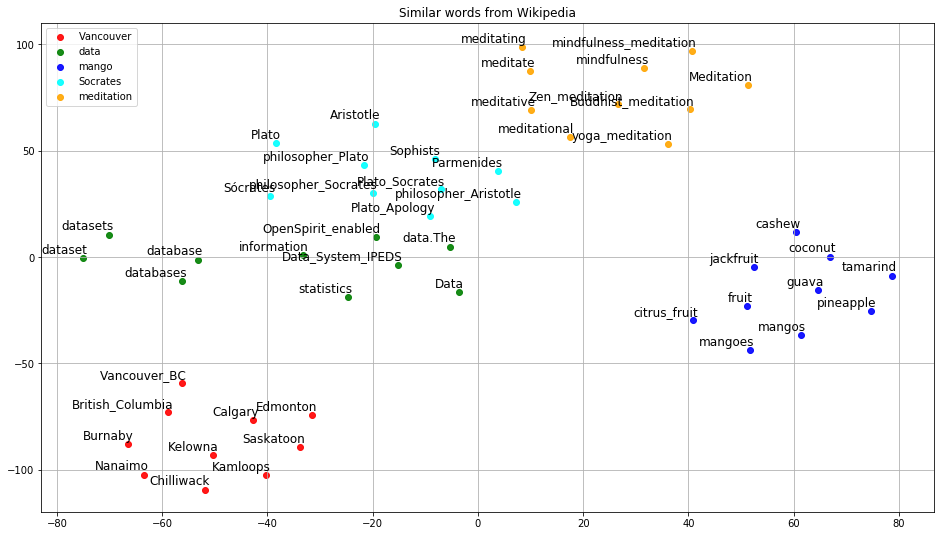

In [95]:
tsne_plot_similar_words('Similar words from Wikipedia', keys, embeddings_en_2d, word_clusters,  0.9)


In [96]:
model.most_similar('mango')

[('mangoes', 0.7850891351699829),
 ('mangos', 0.7233096361160278),
 ('guava', 0.7192398905754089),
 ('coconut', 0.6775304079055786),
 ('jackfruit', 0.6722090244293213),
 ('pineapple', 0.6678789854049683),
 ('tamarind', 0.6678106188774109),
 ('citrus_fruit', 0.6667780876159668),
 ('fruit', 0.6631807088851929),
 ('cashew', 0.6624342203140259)]

### Summary

- Vector space model 
    * Modeling word meaning by placing it in a vector space
    * Distance between words in this vector space indicate the relationship between them
- Word embeddings
    * Creating short and dense representations of words 
- Word2Vec
    * A family of models to learn dense vector representations of words
    * Freely available code and pre-trained models 
    * Available for many different languages. 

Note: If there are no embeddings for your language, you know how to build them now 😊. 

### Pre-work for the next class:

- We'll be working with pre-trained embeddings in the next class. 
- Download [Word2Vec  GoogleNews-vectors-negative300](https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit?usp=sharing). (Large file. Compressed size: ~ 1.3 GB).
- Unzip the downloaded file.
- Load the model using `gensim` as we did above. 
- We'll work with the loded model in the next class. 

### Lab overview

## Relevant papers

- [Distributed representations of words and phrases and their compositionality](https://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf)
- [Efficient estimation of word representations in vector space](https://arxiv.org/pdf/1301.3781.pdf)
- [Linguistic regularities in continuous space word representations](https://www.aclweb.org/anthology/N13-1090)
- [Enriching Word Vectors with Subword Information](http://aclweb.org/anthology/Q17-1010)


## Links for pre-trained embeddings
- [GloVe](https://nlp.stanford.edu/projects/glove/)
- [fastText pre-trained embeddings for 294 languages](https://fasttext.cc/docs/en/pretrained-vectors.html) 

## Fun tools
[wevi: word embedding visual inspector](https://ronxin.github.io/wevi/)